In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
contexts = {
    0: "Unknown",
    1: "Separation",
    2: "Biting",
    3: "Feeding",
    4: "Fighting",
    5: "Grooming",
    6: "Isolation",
    7: "Kissing",
    8: "Landing",
    9: "Mating protest",
    10: "Threat-like",
    11: "General",
    12: "Sleeping",
}

### Import packages

In [4]:
import pandas as pd
from pathlib2 import Path
import numpy as np
from avgn_paper.utils.audio import load_wav
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
from tqdm.autonotebook import tqdm

from avgn_paper.signalprocessing.spectrogramming_tf import spectrogram_tensorflow
from avgn_paper.utils.audio import load_wav, float32_to_int16, int16_to_float32, write_wav
from avgn_paper.visualization.spectrogram import visualize_spec, plot_spec
from avgn_paper.utils.general import HParams

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### load data

In [5]:
DSLOC = Path('/mnt/cube/Datasets/FruitBat/').resolve()

In [6]:
annotations =  pd.read_csv(DSLOC/'Annotations.csv')

In [7]:
file_info = pd.read_csv('/mnt/cube/Datasets/FruitBat/FileInfo.csv', names = np.arange(50))
file_info.columns = file_info.loc[0].values
file_info = file_info[1:]

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (0,1,4,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
# get wavs currently on the disk
wavs_on_disk = list(DSLOC.expanduser().glob('files*/'))
wavs_on_disk = [i for i in wavs_on_disk if i.is_dir() == True]
file_info_on_disk = file_info[file_info['File folder'].isin([_dir.name for _dir in wavs_on_disk])]
annotations_on_disk = annotations[annotations['FileID'].isin(list(np.unique(file_info_on_disk.FileID.values)))]

### Make a list of most common emitters

In [9]:
emitter_freq = pd.DataFrame({emm: [np.sum(annotations_on_disk.Emitter == emm)] for emm in np.unique(annotations_on_disk.Emitter)}).T
emitter_freq.columns = ['N_voc']
emitter_freq = emitter_freq.sort_values(by='N_voc', ascending=False)
emitter_freq[:5]

N_voc
 215   2672
-215   2024
 230   1971
-231   1339
-230   1286

### get one data point

In [229]:
randidx = np.random.permutation(annotations_on_disk.index)[0]
example_file = file_info_on_disk[file_info_on_disk.FileID == annotations_on_disk.loc[randidx].FileID]
example_file

FileID Treatment ID               File name File folder  \
232347  232347           17  130407135005903611.WAV    files218   

       Recording channel       Recording time Voice start sample (1)  \
232347                 1  2013-04-07 14:02:04                  50741   

       Voice end sample (1) Voice start sample (2) Voice end sample (2)  ...  \
232347                60626                  61038                70204  ...   

        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
232347  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[1 rows x 50 columns]

In [230]:
# get start and end times from this file
start_times = example_file.values[:,6:][pd.isnull(example_file.values[:,6:]) == False][::2]
# get start and end times from this file
end_times = example_file.values[:,6:][pd.isnull(example_file.values[:,6:]) == False][1:][::2]
print(start_times, end_times)

[50741 61038.0 88477.0 137351.0 249351.0] [60626 70204.0 98960.0 148005.0 259356.0]


In [231]:
wav_path = DSLOC / example_file['File folder'].values[0] / example_file['File name'].values[0]
wav_path

PosixPath('/mnt/cube/Datasets/FruitBat/files218/130407135005903611.WAV')

In [232]:
rate, data = load_wav(wav_path)
print(rate, len(data))

250000 410448


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


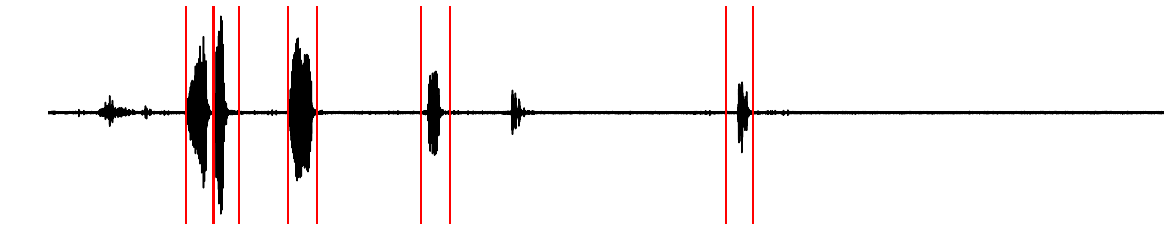

In [233]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
plt.plot(data, color='black')
ax.set_xlim((0, len(data)))
ax.axis('off')
for st, et in zip(start_times, end_times):
    ax.axvline(x=st, color = 'red', lw=2)
    ax.axvline(x=et, color='red', lw=2)
plt.show()

In [234]:
# play back a sample of the song
IPython.display.Audio(data=data, rate=int(rate/5))

In [16]:
win_length_ms = 1
hop_length_ms = .1

hparams = HParams(  
    # spectrogramming
    win_length = int(rate/1000 * win_length_ms),
    n_fft = 2048,
    hop_length= int(rate/1000 * hop_length_ms),
    ref_level_db = 20,
    min_level_db = -75,
)

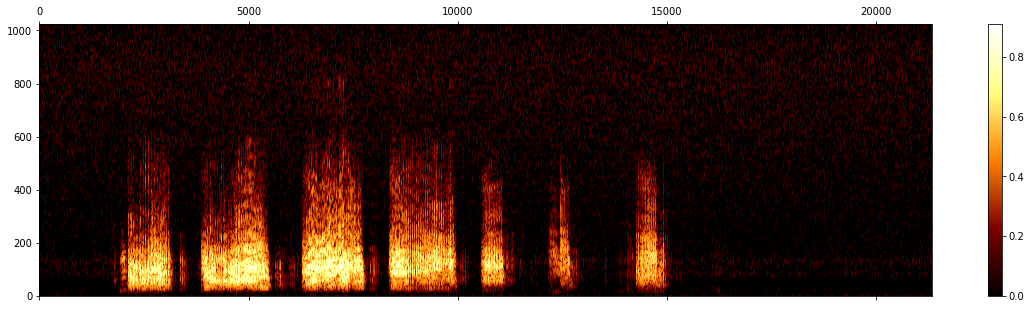

In [17]:
spectrogram = spectrogram_tensorflow(int16_to_float32(data), hparams)
visualize_spec(spectrogram.numpy().T, show=True, cmap = plt.cm.viridis)

### loop through most common emitters and plot most common contexts

In [547]:
win_length_ms = 1
hop_length_ms = .25

In [548]:
int(rate/1000 * win_length_ms)

250

In [644]:
hparams = HParams(  
    # spectrogramming
    win_length = int(rate/1000 * win_length_ms),
    n_fft = 2048,
    hop_length= int(rate/1000 * hop_length_ms),
    ref_level_db = 20,
    min_level_db = -35,
    # mel scaling
    num_mel_bins = 64,
    mel_lower_edge_hertz = 3400,
    mel_upper_edge_hertz = 38000,
    # inversion
    power = 1.5, # for spectral inversion
    griffin_lim_iters = 50,
    pad=True,
    #
)

In [645]:
from avgn_paper.utils.audio import int16_to_float32

In [646]:
syllable = data[start_times[0]:end_times[0]]

In [647]:
len(syllable)/rate

0.064596

In [648]:
spectrogram = spectrogram_tensorflow(int16_to_float32(syllable), hparams)

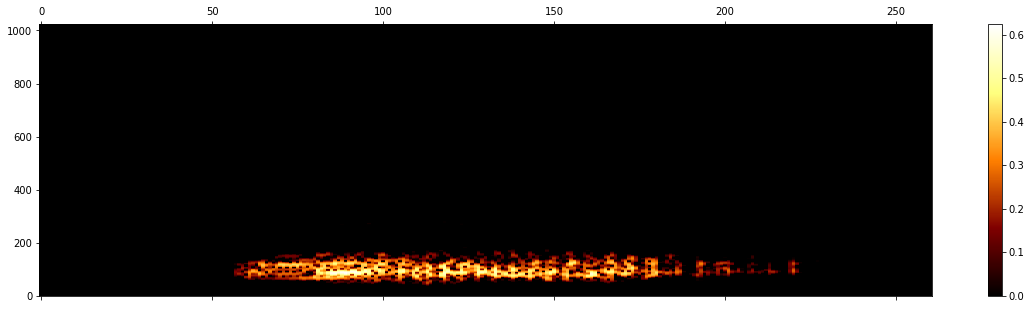

In [649]:
visualize_spec(spectrogram.numpy().T, show=True)

In [650]:
import tensorflow as tf

In [651]:
# create a filter to convolve with the spectrogram
mel_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=hparams.num_mel_bins,
    num_spectrogram_bins=int(hparams.n_fft/2)+1,
    sample_rate=rate,
    lower_edge_hertz=hparams.mel_lower_edge_hertz,
    upper_edge_hertz=hparams.mel_upper_edge_hertz,
    dtype=tf.dtypes.float32,
    name=None,
)

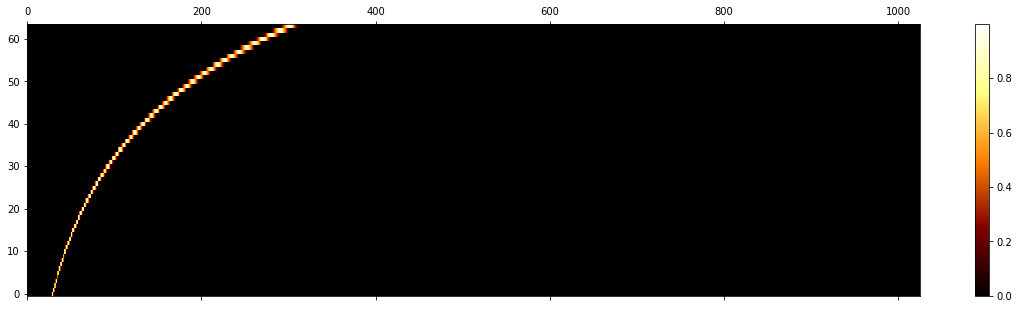

In [652]:
visualize_spec(mel_matrix.numpy().T, show=True)

In [653]:
from librosa.core.time_frequency import mel_frequencies

In [654]:
# gets the center frequencies of mel bands
mel_f = mel_frequencies(
    n_mels=hparams.num_mel_bins + 2,
    fmin=hparams.mel_lower_edge_hertz,
    fmax=hparams.mel_upper_edge_hertz,
)

In [655]:
# Slaney-style mel is scaled to be approx constant energy per channel (from librosa)
enorm = tf.dtypes.cast(
    tf.expand_dims(tf.constant(2.0 / (mel_f[2 : hparams.num_mel_bins + 2] - mel_f[:hparams.num_mel_bins])), 0),
    tf.float32,
)

In [656]:
mel_matrix = tf.multiply(mel_matrix, enorm)
mel_matrix = tf.divide(mel_matrix, tf.reduce_sum(mel_matrix, axis=0))

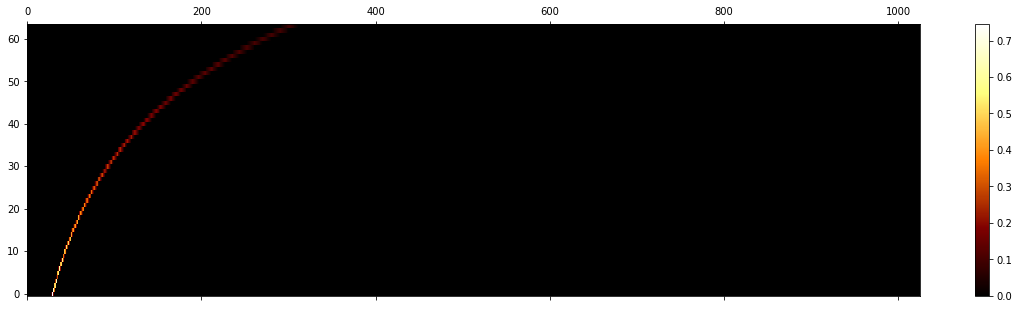

In [657]:
visualize_spec(mel_matrix.numpy().T, show=True)

In [658]:
mel_spectrogram = tf.tensordot(spectrogram,mel_matrix, 1)

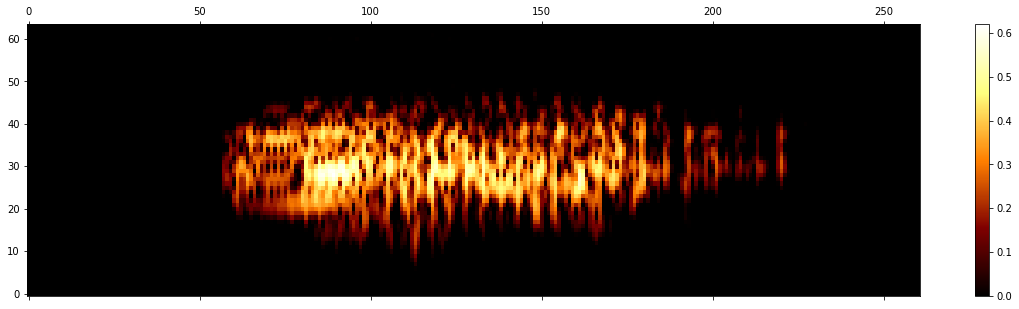

In [659]:
visualize_spec(mel_spectrogram.numpy().T, show=True)

### MFCCs

In [660]:
MFCCs = tf.signal.mfccs_from_log_mel_spectrograms(mel_spectrogram)

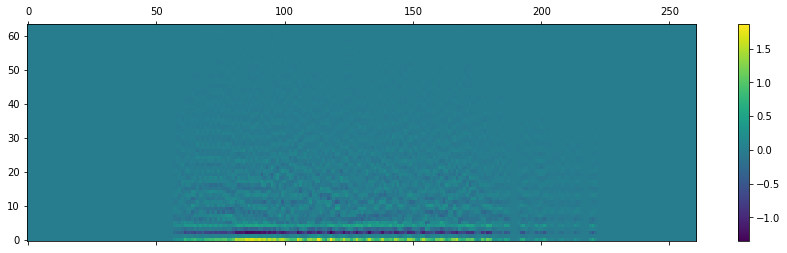

In [661]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
cax = ax.matshow((MFCCs.numpy().T), aspect='auto', origin='lower')
fig.colorbar(cax)

### plot several Mel Spectrograms

In [662]:
n_contexts = 1
nrow = 10
ncol = 10
zoom_x = 3
zoom_y = 2

In [663]:
import warnings
warnings.filterwarnings('ignore')

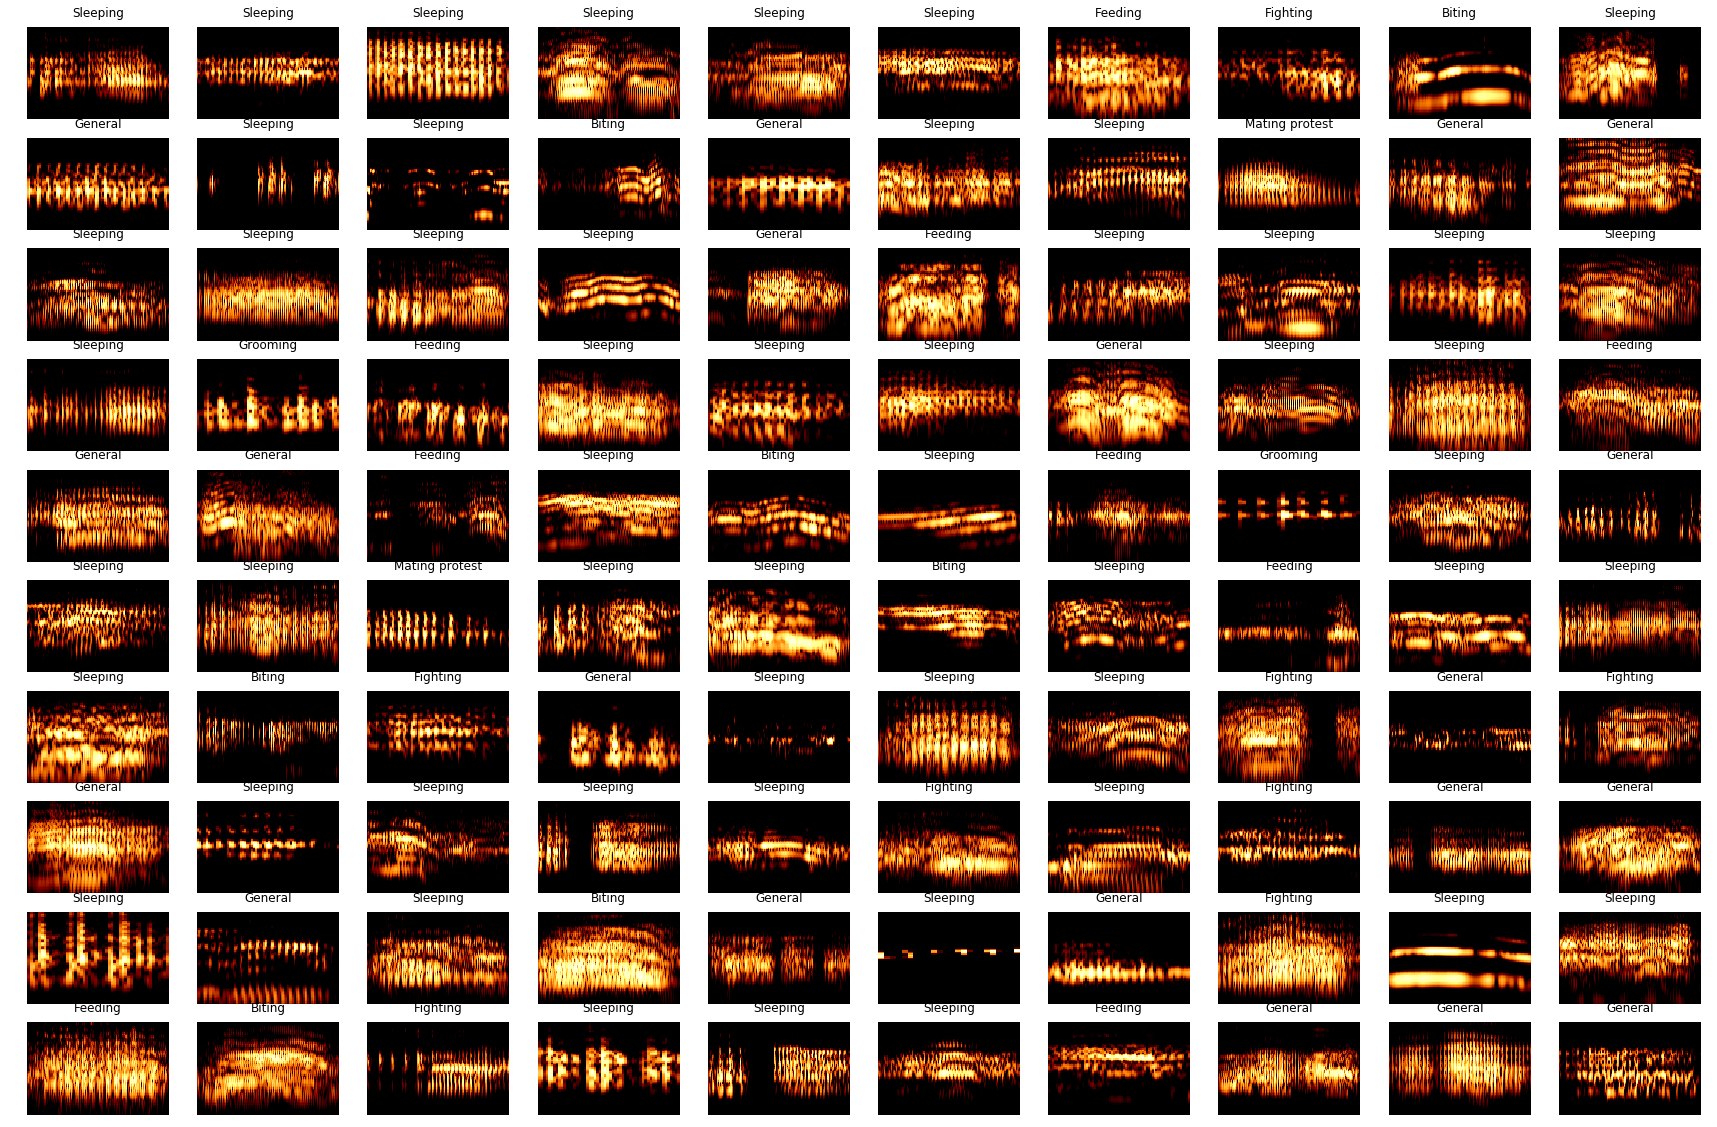

In [664]:
fig, axs = plt.subplots(nrows = nrow, ncols=ncol, figsize=(ncol*zoom_x, nrow*zoom_y))
for cn in tqdm(range(nrow*ncol)):
    ax = axs.flatten()[cn]
    randidx = np.random.permutation(annotations_on_disk.index)[0]
    example_file = file_info_on_disk[file_info_on_disk.FileID == annotations_on_disk.loc[randidx].FileID]
    # get start and end times from this file
    start_times = example_file.values[:,6:][pd.isnull(example_file.values[:,6:]) == False][::2]
    # get start and end times from this file
    end_times = example_file.values[:,6:][pd.isnull(example_file.values[:,6:]) == False][1:][::2]
    wav_path = DSLOC / example_file['File folder'].values[0] / example_file['File name'].values[0]
    rate, data = load_wav(wav_path)
    syllable = data[start_times[0]:end_times[0]]
    spectrogram = spectrogram_tensorflow(int16_to_float32(syllable), hparams)
    mel_spectrogram = tf.tensordot(spectrogram,mel_matrix, 1)
    mel_spectrogram = mel_spectrogram/np.max(mel_spectrogram)
    # thresholding
    threshed = np.mean(mel_spectrogram.numpy(),axis=1) > 0.05
    #if np.sum(threshed) == 0: continue
    begin, end = np.where(threshed == 1)[0][np.array([0,-1])]
    # plot
    plot_spec(mel_spectrogram.numpy().T[:,begin:end], fig=fig, ax=ax, show_cbar=False)
    context = contexts[annotations_on_disk[annotations_on_disk.FileID == example_file.FileID.values[0]].Context.values[0]]
    ax.set_title(context)
for ax in axs.flatten():
    ax.axis('off')

### Make spectrograms of everything

In [672]:
annotations_on_disk[:3]

FileID  Emitter  Addressee  Context  Emitter pre-vocalization action  \
11675   50001     -109          0       12                                2   
11676   50002     -119          0        4                                2   
11677   50005     -119          0        4                                2   

       Addressee pre-vocalization action  Emitter post-vocalization action  \
11675                                  2                                 3   
11676                                  2                                 3   
11677                                  2                                 3   

       Addressee post-vocalization action  Start sample  End sample  
11675                                   3             1      328528  
11676                                   3             1      582480  
11677                                   3        179671      475984

In [673]:
largest_emitters = pd.DataFrame({
    emitter: [np.sum(np.abs(annotations_on_disk.Emitter) == emitter)]
    for emitter in np.unique(np.abs(annotations_on_disk.Emitter))
    if np.sum(np.abs(annotations_on_disk.Emitter) == emitter) > 1000
}).T#.reset_index()
largest_emitters.columns = ['n_voc']
largest_emitters.sort_values(by='n_voc', ascending=False).T

215   230   231   211   216   220   210   207   208   221
n_voc  4696  3257  2405  2249  1891  1805  1561  1556  1161  1002

In [674]:
large_emmitters_annotations = annotations_on_disk[np.abs(annotations_on_disk.Emitter).isin(largest_emitters.index)]
print(len(large_emmitters_annotations))
large_emmitters_annotations[:3]

21583


FileID  Emitter  Addressee  Context  Emitter pre-vocalization action  \
64780  223437      215        207        9                                2   
64781  223444     -230       -207       12                                2   
64782  223446     -230       -207       12                                2   

       Addressee pre-vocalization action  Emitter post-vocalization action  \
64780                                  2                                 3   
64781                                  2                                 3   
64782                                  2                                 3   

       Addressee post-vocalization action  Start sample  End sample  
64780                                   3             1      328528  
64781                                   3             1      975696  
64782                                   3             1      402256

In [675]:
from joblib import Parallel, delayed
n_jobs = 10
verbosity = 5

In [ ]:
def make_spec(row, example_file, DSLOC):
    # get start and end times from this file
    start_times = example_file.values[:,6:][pd.isnull(example_file.values[:,6:]) == False][::2]
    # get start and end times from this file
    end_times = example_file.values[:,6:][pd.isnull(example_file.values[:,6:]) == False][1:][::2]
    wav_path = DSLOC / example_file['File folder'].values[0] / example_file['File name'].values[0]
    rate, data = load_wav(wav_path)
    syllable = data[start_times[0]:end_times[0]]
    spectrogram = spectrogram_tensorflow(int16_to_float32(syllable), hparams)
    mel_spectrogram = tf.tensordot(spectrogram,mel_matrix, 1).numpy()
    # thresholding
    mel_spectrogram = mel_spectrogram/np.max(mel_spectrogram)
    threshed = np.mean(mel_spectrogram,axis=1) > 0.05
    begin, end = np.where(threshed == 1)[0][np.array([0,-1])]
    # plot
    spec = mel_spectrogram.numpy().T[:,begin:end]
    spec = (spec * 255).astype('uint8')
    return spec

In [ ]:
large_emmitters_annotations[:3]

In [ ]:
# this needs to be done in 
specs = [make_spec(row, file_info_on_disk[file_info_on_disk.FileID == row.FileID], DSLOC) for idx, row in tqdm(
            large_emmitters_annotations.iterrows(),
            total=len(large_emmitters_annotations),
        )]

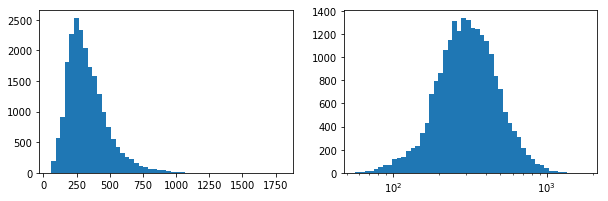

In [671]:
spec_lens = [np.shape(i)[1] for i in specs]
# syllable length is roughly lognormal... so lets scale them accordingly
fig, axs = plt.subplots(ncols=2, figsize=(10,3))
hist, bins, _ = axs[0].hist(spec_lens, bins=50)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
axs[1].hist(spec_lens, bins=logbins)
axs[1].set_xscale('log')
plt.show()

In [122]:
from PIL import Image 
def log_resize_spec(spec):
    resize_shape = [int(np.log(np.shape(spec)[1])*10), 64]
    resize_spec = Image.fromarray(spec).resize(resize_shape, Image.ANTIALIAS)
    return resize_spec

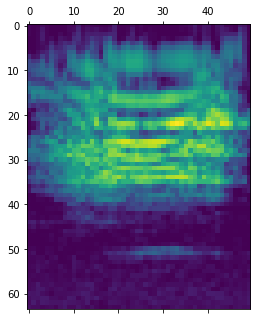

In [123]:
smaller_spec = log_resize_spec(specs[2000])
plt.matshow(smaller_spec)

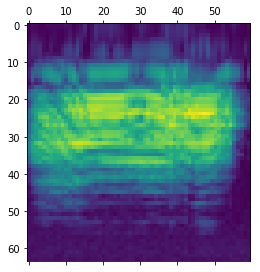

In [124]:
smaller_spec = log_resize_spec(specs[100])
plt.matshow(smaller_spec)

In [125]:
with Parallel(n_jobs=24, verbose=verbosity) as parallel:
    specs_smaller = parallel(
        delayed(log_resize_spec)(spec)
        for spec in tqdm(
            specs
        )
    )

[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 2352 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 16572 tasks      | elapsed:    3.1s
[Parallel(n_jobs=24)]: Done 21583 out of 21583 | elapsed:    4.0s finished


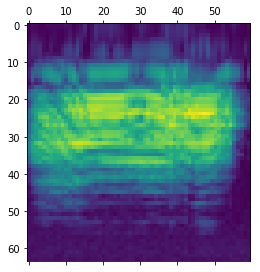

In [126]:
plt.matshow(specs_smaller[100])

In [135]:
spec_lens = [np.shape(i)[1] for i in specs_smaller]
np.max(spec_lens)

74

In [ ]:
## now pad spectrograms

In [136]:
def pad_spectrogram(spectrogram, pad_length):
    """ Pads a spectrogram to being a certain length
    """
    excess_needed = pad_length - np.shape(spectrogram)[1]
    pad_left = np.floor(float(excess_needed) / 2).astype("int")
    pad_right = np.ceil(float(excess_needed) / 2).astype("int")
    return np.pad(
        spectrogram, [(0, 0), (pad_left, pad_right)], "constant", constant_values=0
    )

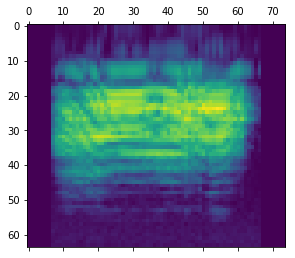

In [137]:
padded_spec=  pad_spectrogram(specs_smaller[100], 74)
plt.matshow(padded_spec)

In [139]:
with Parallel(n_jobs=24, verbose=verbosity) as parallel:
    specs_padded = parallel(
        delayed(pad_spectrogram)(spec, 74)
        for spec in tqdm(
            specs_smaller
        )
    )

[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  24 tasks      | elapsed:    1.6s
[Parallel(n_jobs=24)]: Done 309 tasks      | elapsed:    1.7s
[Parallel(n_jobs=24)]: Done 21583 out of 21583 | elapsed:    3.0s finished


In [141]:
np.save('padded_bat_specs.npy', np.array(specs_padded))

In [149]:
cn

(0,)

In [147]:
len(annotations_on_disk)

22870

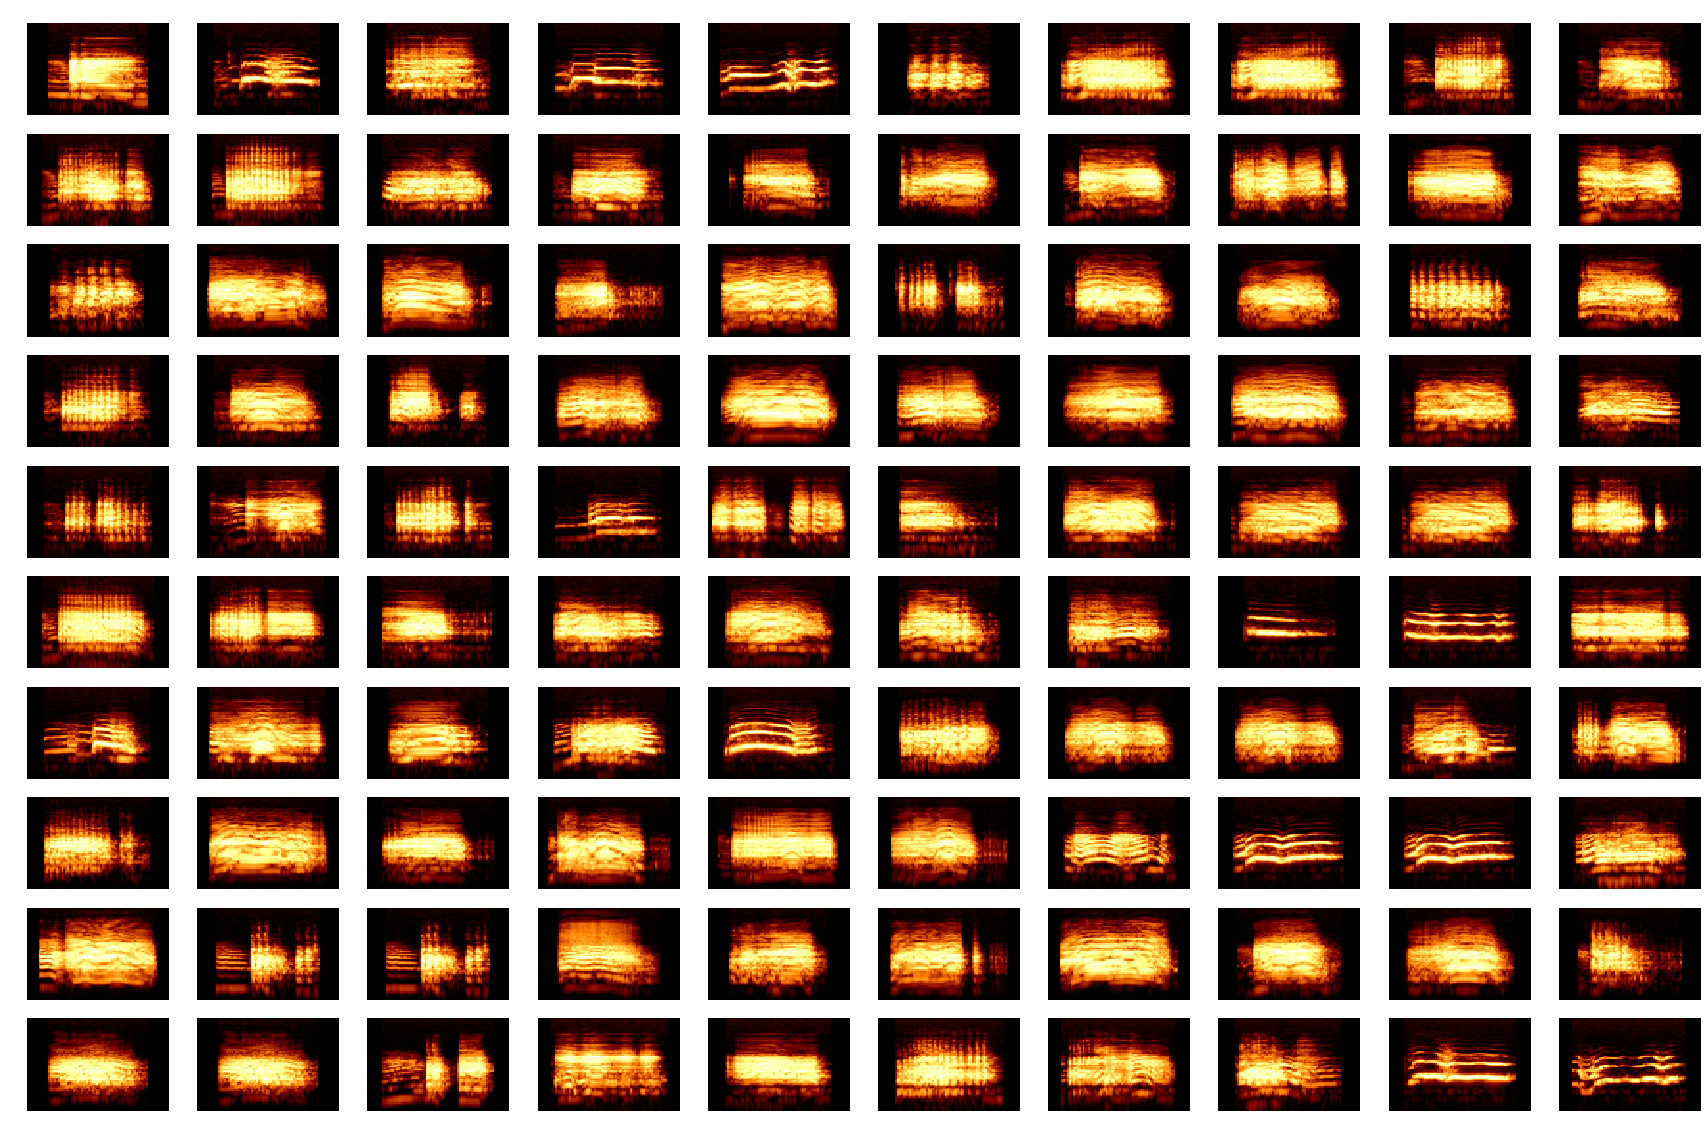

In [151]:
nrow = 10
ncol = 10
fig, axs = plt.subplots(nrows = nrow, ncols=ncol, figsize=(ncol*zoom_x, nrow*zoom_y))
for cn in tqdm(range(nrow*ncol)):
    ax = axs.flatten()[cn]
    plot_spec(specs_padded[cn], fig=fig, ax=ax, show_cbar=False)
for ax in axs.flatten():
    ax.axis('off')

In [152]:
np.shape(specs_padded)

(21583, 64, 74)

In [156]:
specs_flattened = np.reshape(specs_padded, (np.shape(specs_padded)[0], np.prod(np.shape(specs_padded)[1:])))

In [153]:
import umap

In [157]:
fit = umap.UMAP()
%time u = fit.fit_transform(specs_flattened)

CPU times: user 1min 20s, sys: 7.86 s, total: 1min 28s
Wall time: 1min 10s


In [165]:
large_emmitters_annotations[:3]

FileID  Emitter  Addressee  Context  Emitter pre-vocalization action  \
64780  223437      215        207        9                                2   
64781  223444     -230       -207       12                                2   
64782  223446     -230       -207       12                                2   

       Addressee pre-vocalization action  Emitter post-vocalization action  \
64780                                  2                                 3   
64781                                  2                                 3   
64782                                  2                                 3   

       Addressee post-vocalization action  Start sample  End sample  
64780                                   3             1      328528  
64781                                   3             1      975696  
64782                                   3             1      402256

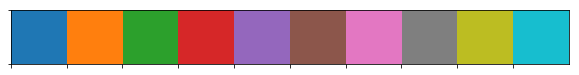

In [189]:
import seaborn as sns
labs = np.abs(large_emmitters_annotations.Emitter.values)
pal = sns.color_palette(n_colors=len(np.unique(labs)))
sns.palplot(pal)
lab_dict = {lab:pal[i] for i, lab in enumerate(np.unique(labs))}
colors = [lab_dict[i] for i in labs]

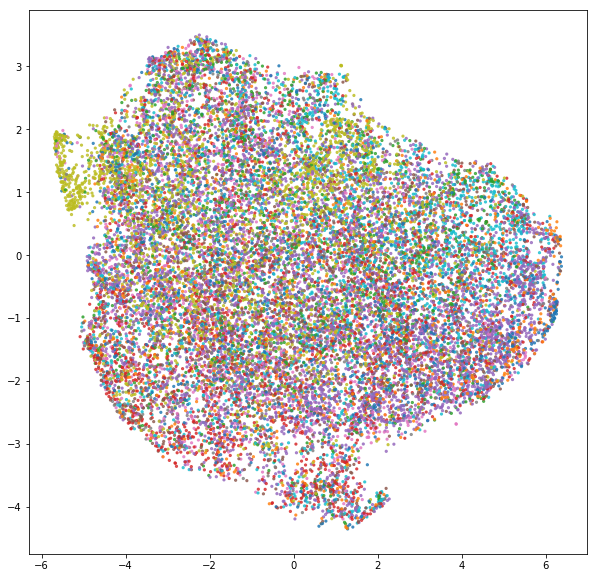

In [190]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(u[:,0], u[:,1], alpha = 0.75, s=5, color = colors)

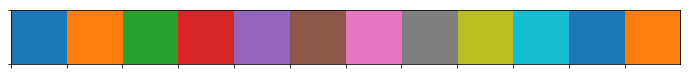

In [191]:
import seaborn as sns
labs = np.abs(large_emmitters_annotations.Context.values)
pal = sns.color_palette(n_colors=len(np.unique(labs)))
sns.palplot(pal)
lab_dict = {lab:pal[i] for i, lab in enumerate(np.unique(labs))}
colors = [lab_dict[i] for i in labs]

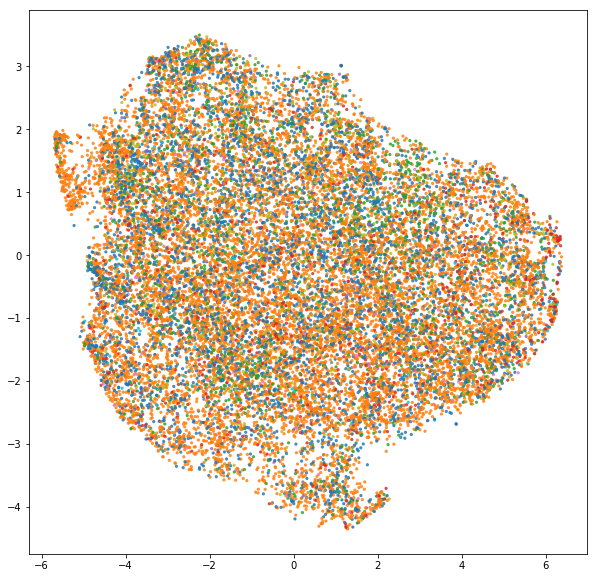

In [192]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(u[:,0], u[:,1], alpha = 0.75, s=5, color = colors)

### supervised UMAP

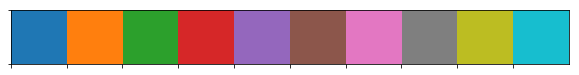

In [193]:
import seaborn as sns
labs = np.abs(large_emmitters_annotations.Emitter.values)
pal = sns.color_palette(n_colors=len(np.unique(labs)))
sns.palplot(pal)
lab_dict = {lab:pal[i] for i, lab in enumerate(np.unique(labs))}
colors = [lab_dict[i] for i in labs]

In [194]:
fit = umap.UMAP()
%time u = fit.fit_transform(specs_flattened, y = labs)

CPU times: user 1min 5s, sys: 9.64 s, total: 1min 15s
Wall time: 51.7 s


(-8, 10)

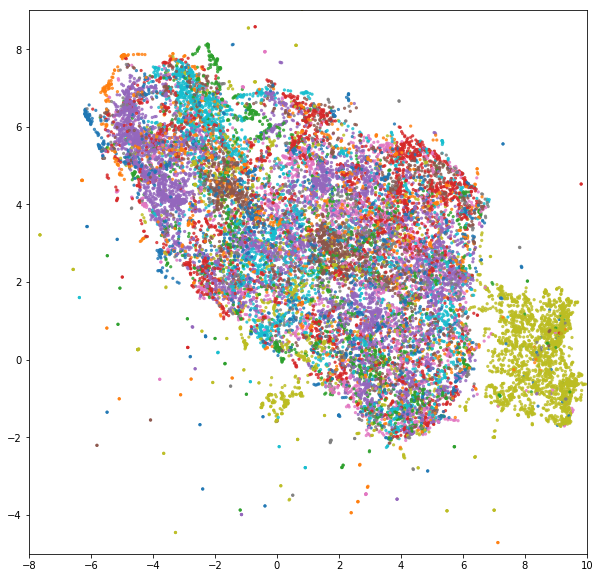

In [200]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(u[:,0], u[:,1], alpha = 0.75, s=5, color = colors)
ax.set_ylim([-5, 9])
ax.set_xlim([-8, 10])